# Deep Reinforcement Learning, due 5/12/2022.

In [53]:
import torch as th
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

## Exercise 1: Implement the Neural Fitted Q-Iteration Algorithm

### Task A: Implement a Q-Network class: a Q-function S X A-> |R approximated by a neural network.

In [68]:
class Q(th.nn.Module):
    def __init__(self, env, hidden_size=64, hidden_layers = 2, activ=th.nn.ReLU, optimizer=th.optim.Adam):
        super().__init__()
        self.env = env
        
        self.layers = th.nn.Sequential(th.nn.Linear(self.env.observation_space.shape[0]+1, hidden_size),
                                      activ(),
                                      th.nn.Linear(hidden_size,hidden_size),
                                      activ(),
                                      th.nn.Linear(hidden_size, 1))
        
        self.optimizer = optimizer(self.parameters())
        self.optimizer.zero_grad()

    def forward(self, states_actions ):
        q_s_a = self.layers(states_actions)
        return q_s_a
    
    def get_best_action(self, state):
        best = -np.inf
        best_a = 0
        with th.no_grad():
            for a in range(self.env.action_space.n):
                val = self.forward(th.FloatTensor(np.append(state,[a])))
                if val> best:
                    best = val
                    best_a = a
        return best, best_a

### Task B: write a function to fit your Q-network on a batch of transitions.

In [69]:
MSE = th.nn.MSELoss()
def fit(Q, batch, gamma = 0.99):
    #batch size X : s + a + r + snext + done
    Q.optimizer.zero_grad()
    
    
    predictions = Q.forward(batch[:, :Q.env.observation_space.shape[0] + 1]) #On récup Q(s,a)
    r = batch[:, Q.env.observation_space.shape[0] + 1:Q.env.observation_space.shape[0] + 2] #On récup le r
    s_next = batch[:, Q.env.observation_space.shape[0] + 2:-1] #On récup s'
    dones = batch[:,-1]
    targs = th.zeros_like(dones)
    for i, s in enumerate(s_next):
        targs[i] = ( r[i] + gamma * Q.get_best_action(s)[0] * (1 - dones[i]))
    
    loss = MSE(predictions, targs)
    loss.backward()  
    Q.optimizer.step()
    
    return loss.item()

### Task C: test Neural Fitted Q-Iteration on CartPole and Acrobot and extract some policies.

In [73]:
cartpole = gym.make("CartPole-v0")

def nfq(env, iterations = 1000, batch_size = 100,activ=th.nn.ReLU,gamma = 0.99):
    qnet = Q(env,activ=activ)
    losses = []
    for it in tqdm(range(iterations)):
        #1. get a batch
        batch = np.zeros((batch_size, 2 * env.observation_space.shape[0] + 3))
        s = env.reset()
        for i in range(batch_size):           
            a = env.action_space.sample()
            snext, r, done, infos = env.step(a)
            transition = np.array([*s, a, r, *snext, int(done)])
            batch[i] = transition
            if done:
                s = env.reset()
            else:
                s = snext
                
        #convert batch of np.arrays to tensors
        batch = th.FloatTensor(batch)
        
        #2. fit Q-network on batch
        loss = fit(qnet, batch, gamma=gamma)
        losses.append(loss)
    
    return qnet, losses


def policy(qnet, s):
    _,action = qnet.get_best_action(s)
    return action

def evaluate(env, qnet, nb_episode = 100):
    scores = []
    for i in range(nb_episode):
        cumulative_reward = 0
        s = env.reset()
        done = False
        
        while not done:
            env.state = s
            a = policy(qnet, th.tensor(s))
            next_state, reward, done, info = env.step(a)
            cumulative_reward += reward
            s = next_state.copy()
            
        scores.append(cumulative_reward)
    return scores

#plot losses and analyse evaluations


q, losses = nfq(cartpole)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/hkohler/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [00:23<00:00, 42.83it/s]


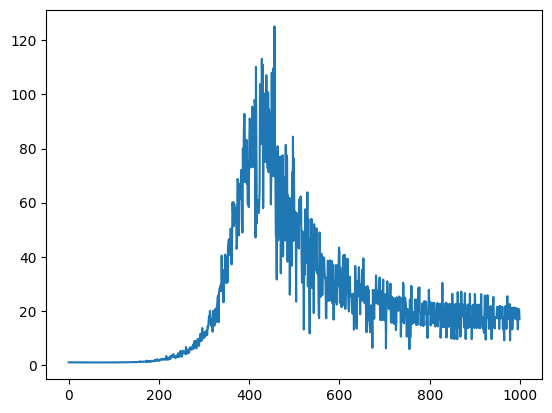

In [74]:
plt.plot(losses)
plt.show()
evals = evaluate(cartpole, q)

In [75]:
np.array(evals).mean()

41.92

## Exercise 2: Implement the Deep Q-Networks algorithm with a replay buffer and study its performance on Acrobot and Cartpole.  
### Bonus: Implement DQN + raplay + target Q-Network and compare its performances with DQN + replay.